Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)


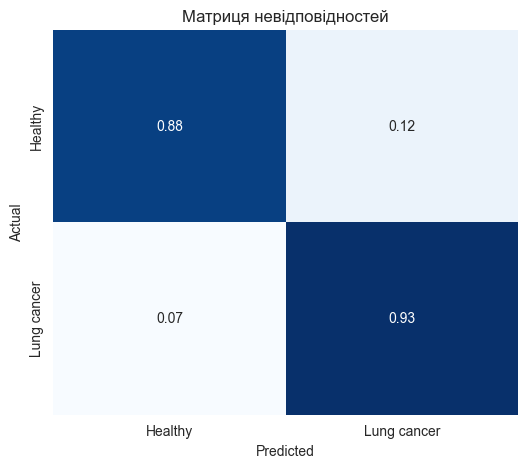

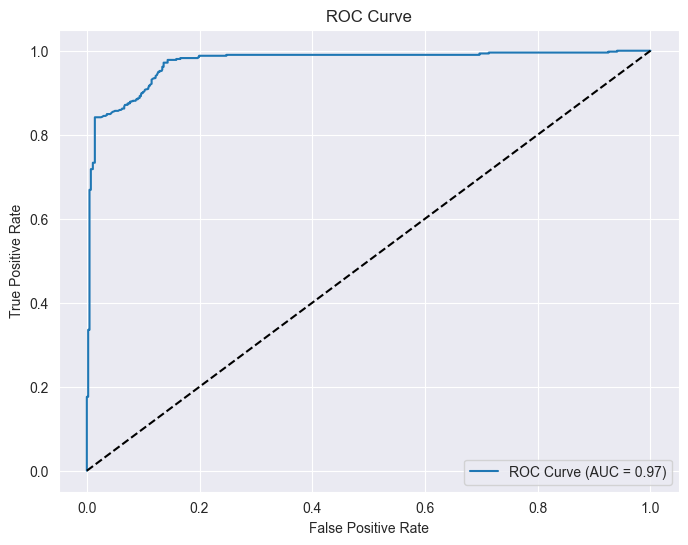

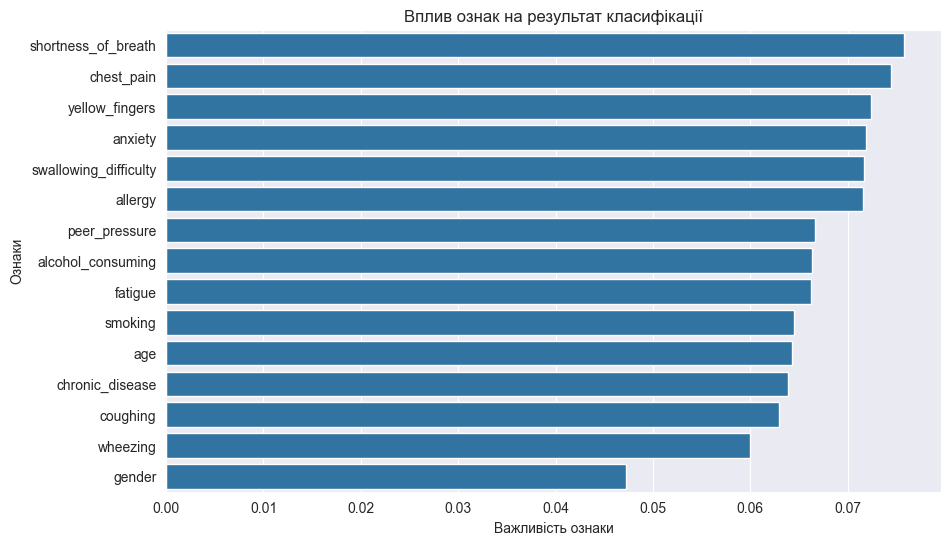

Train accuracy: 96.26 %
Test accuracy: 90.9 %
              precision    recall  f1-score      support
0              0.925373  0.881517  0.902913   844.000000
1              0.895288  0.934426  0.914439   915.000000
accuracy       0.909039  0.909039  0.909039     0.909039
macro avg      0.910331  0.907971  0.908676  1759.000000
weighted avg   0.909723  0.909039  0.908908  1759.000000


In [6]:
from db_connection import sqlalchemy_engine
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Завантаження даних
query = """SELECT
    g.gender,
    p.age,
    l.smoking,
    l.alcohol_consuming,
    l.peer_pressure,
    m.anxiety,
    m.yellow_fingers,
    m.chronic_disease,
    m.fatigue,
    m.allergy,
    m.wheezing,
    m.coughing,
    m.shortness_of_breath,
    m.swallowing_difficulty,
    m.chest_pain,
    d.lung_cancer
FROM safe.facts_lung_cancer_facts f
JOIN safe.dim_patients p ON f.patient_id = p.id
JOIN safe.dim_gender g ON p.gender_id = g.id
JOIN safe.dim_lifestyle l ON f.lifestyle_id = l.id
JOIN safe.dim_medical_conditions m ON f.medical_id = m.id
JOIN safe.dim_diagnosis d ON f.diagnosis_id = d.id;
"""
df = pd.read_sql(query, sqlalchemy_engine)

# Перетворення категорій
df['gender'] = df['gender'].str.strip().map({'Male': 1, 'Female': 0})
df['lung_cancer'] = df['lung_cancer'].str.strip().map({'Lung cancer patient': 1, 'Healthy': 0})

# X – ознаки, y – ціль (виключаємо 'age', як у вашому коді)
X = df.drop(columns=['lung_cancer'])
y = df['lung_cancer']

# Стандартизація
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Поділ на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Сітка параметрів для XGBoost
param_grid = {
    "n_estimators": [100, 150, 200, 300],
    "max_depth": [3, 5, 7],  # XGBoost зазвичай працює з меншою глибиною
    "learning_rate": [0.01, 0.1, 0.3],  # Крок навчання
    "subsample": [0.8, 1.0],  # Доля даних для кожного дерева
    "colsample_bytree": [0.8, 1.0]  # Доля ознак для кожного дерева
}
grid = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

# Найкраща модель
model = grid.best_estimator_
print("Best model:", grid.best_estimator_)

# Прогноз
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_test_proba = model.predict_proba(X_test)[:, 1]

# Метрики
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
conf_matrix = confusion_matrix(y_test, y_pred_test, normalize='true')

# Важливість ознак
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Візуалізації
# Матриця невідповідностей
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=["Healthy", "Lung cancer"], yticklabels=["Healthy", "Lung cancer"])
plt.title("Матриця невідповідностей")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ROC-крива
fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_test_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Важливість ознак
plt.figure(figsize=(10, 6))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Вплив ознак на результат класифікації")
plt.ylabel("Ознаки")
plt.xlabel("Важливість ознаки")
plt.show()

# Виведення результатів
print("Train accuracy:", round(train_acc * 100, 2), "%")
print("Test accuracy:", round(test_acc * 100, 2), "%")
print(report_df)